In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

In [39]:
input_file='D:/学习资料/DataScience/TB2/Mini-project/model/AQI_X_data.csv'

data=pd.read_csv(input_file)
data = data[data['Year'] > 2019]
data = data.drop(['geo_point_2d','ZipCode','Type of tree'],axis=1)
#delete Tree air clean
#data = data.drop(data.columns[-3:], axis=1)

C:\Users\sylvia\AppData\Local\Temp\ipykernel_15212\3661503719.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(input_file)


In [31]:
EV_quater_df = pd.read_csv('D:/学习资料/DataScience/TB2/Mini-project/data_cleaning/EV_Quater.csv')   
EV_quater_df['Heavy goods vehicles'] = 5


EV_quater_df['Cars'] = EV_quater_df['Cars'].astype(int)
EV_quater_df['Heavy goods vehicles'] = EV_quater_df['Heavy goods vehicles'].astype(int)
EV_quater_df['Light goods vehicles'] = EV_quater_df['Light goods vehicles'].astype(int)
EV_quater_df['Motorcycles'] = EV_quater_df['Motorcycles'].astype(int)
EV_quater_df['Total'] = EV_quater_df['Total'].astype(int)
#EV_quater_df.iloc[:, 1:] = EV_quater_df.iloc[:, 1:].astype(int)

EV_quater_df['Other vehicles'] =EV_quater_df['Total']-EV_quater_df['Heavy goods vehicles']-EV_quater_df['Cars']-EV_quater_df['Light goods vehicles']-EV_quater_df['Motorcycles']


,Time,Cars,Heavy goods vehicles,Light goods vehicles,Motorcycles,Other vehicles,Total
0,2022 Q3,3066,5,389,140,11,3611
1,2022 Q2,2811,5,368,129,3,3316
2,2022 Q1,2595,5,353,127,3,3083
3,2021 Q4,2335,5,358,126,3,2827
4,2021 Q3,2128,5,343,109,3,2588
5,2021 Q2,1889,5,307,96,2,2299
6,2021 Q1,1657,5,276,75,1,2014
7,2020 Q4,1551,5,241,70,0,1867
8,2020 Q3,1372,5,172,63,0,1612
9,2020 Q2,1186,5,136,57,0,1384


In [40]:
data['Quater'] = data['Month'].apply(lambda x: 'Q1' if x <= 3 else ('Q2' if x <= 6 else ('Q3' if x <= 9 else 'Q4')))
data = data.merge(EV_quater_df,left_on=['Quater'],right_on=['Time'],how='left')
data = data.drop(['Time'],axis=1)
data['Quater'] = data['Month'].apply(lambda x: '1' if x == 'Q1' else ('2' if x == 'Q2' else ('3' if x == 'Q3' else '4'))).astype(int)

In [42]:
data

,Year,Month,Day,Hour,max_AQI,Longitude,Latitude,left_ZipCode,Hourly Flow,Hourly Profile,...,tree_airclean_0,tree_airclean_1,tree_airclean_2,Quater,Cars,Heavy goods vehicles,Light goods vehicles,Motorcycles,Other vehicles,Total
0,2020,1,1,0,2,51.427864,-2.563742,BS14,76.0,72.0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,1,0,2,51.455269,-2.596649,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,0,3,51.457950,-2.583989,BS2,371.2,209.6,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,0,2,51.462829,-2.584541,BS2,371.2,209.6,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,1,7,51.427864,-2.563742,BS14,136.0,32.0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190952,2022,12,31,15,2,51.455269,-2.596649,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190953,2022,12,31,15,1,51.457950,-2.583989,BS2,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190954,2022,12,31,15,1,51.459142,-2.595433,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190955,2022,12,31,15,2,51.462829,-2.584541,BS2,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
#data=data.groupby(['Year','Month','Day','Hour']).mean().reset_index(drop=False)

#data=data.dropna()
print(data.shape,data.isna().sum())
#data.to_csv('D:/学习资料/DataScience/TB2/Mini-project/model/'+'test_data.csv', index=False)
data

(190957, 29) Year                                        0
Month                                       0
Day                                         0
Hour                                        0
max_AQI                                     0
Longitude                                   0
Latitude                                    0
left_ZipCode                                0
Hourly Flow                             72503
Hourly Profile                          72503
Temperature                             62968
Dewpoint Temperature                    62968
Wind Speed                              62968
Visibility                              62968
Wind Chill Temperature                  62968
Relative Humidity                      106272
Daily lab-confirmed cases               61931
Cumulative lab-confirmed cases          61931
Cumulative lab-confirmed cases rate     66111
tree_airclean_0                        190917
tree_airclean_1                        190917
tree_airclean_2      

,Year,Month,Day,Hour,max_AQI,Longitude,Latitude,left_ZipCode,Hourly Flow,Hourly Profile,...,tree_airclean_0,tree_airclean_1,tree_airclean_2,Quater,Cars,Heavy goods vehicles,Light goods vehicles,Motorcycles,Other vehicles,Total
0,2020,1,1,0,2,51.427864,-2.563742,BS14,76.0,72.0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,1,1,0,2,51.455269,-2.596649,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
2,2020,1,1,0,3,51.457950,-2.583989,BS2,371.2,209.6,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
3,2020,1,1,0,2,51.462829,-2.584541,BS2,371.2,209.6,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
4,2020,1,1,1,7,51.427864,-2.563742,BS14,136.0,32.0,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190952,2022,12,31,15,2,51.455269,-2.596649,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190953,2022,12,31,15,1,51.457950,-2.583989,BS2,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190954,2022,12,31,15,1,51.459142,-2.595433,BS1,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
190955,2022,12,31,15,2,51.462829,-2.584541,BS2,NaN,NaN,...,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
#Encode the ZipCode
le = LabelEncoder()

cols_to_transform = ['left_ZipCode']

data[cols_to_transform] = data[cols_to_transform].astype(str)

data[cols_to_transform] = data[cols_to_transform].apply(lambda x: le.fit_transform(x.astype(str)))
data=data.fillna(0)

In [45]:
X = data.drop(['max_AQI'], axis=1)
y = data['max_AQI'].apply(lambda x: x - 1)

In [46]:
X

,Year,Month,Day,Hour,Longitude,Latitude,left_ZipCode,Hourly Flow,Hourly Profile,Temperature,...,tree_airclean_0,tree_airclean_1,tree_airclean_2,Quater,Cars,Heavy goods vehicles,Light goods vehicles,Motorcycles,Other vehicles,Total
0,2020,1,1,0,51.427864,-2.563742,1,76.0,72.0,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,1,1,0,51.455269,-2.596649,0,0.0,0.0,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,1,1,0,51.457950,-2.583989,3,371.2,209.6,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,1,1,0,51.462829,-2.584541,3,371.2,209.6,5.5,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,1,1,1,51.427864,-2.563742,1,136.0,32.0,5.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190952,2022,12,31,15,51.455269,-2.596649,0,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
190953,2022,12,31,15,51.457950,-2.583989,3,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
190954,2022,12,31,15,51.459142,-2.595433,0,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0
190955,2022,12,31,15,51.462829,-2.584541,3,0.0,0.0,11.0,...,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# use LinearRegression to fill na values 
'''
X.replace('', np.nan, inplace=True)

for column in X.columns:
    if X[column].isnull().sum() > 0:
        lm = LinearRegression()
        X_train = X[X[column].notnull()]
        y_train = X_train.pop(column)
        X_test = X[X[column].isnull()]
        X_train = X_train.select_dtypes(include=np.number)
        X_test = X_test.select_dtypes(include=np.number)
        lm.fit(X_train, y_train)
        X.loc[X[column].isnull(), column] = lm.predict(X_test.select_dtypes(include=np.number))
'''

"\nX.replace('', np.nan, inplace=True)\n\nfor column in X.columns:\n    if X[column].isnull().sum() > 0:\n        lm = LinearRegression()\n        X_train = X[X[column].notnull()]\n        y_train = X_train.pop(column)\n        X_test = X[X[column].isnull()]\n        X_train = X_train.select_dtypes(include=np.number)\n        X_test = X_test.select_dtypes(include=np.number)\n        lm.fit(X_train, y_train)\n        X.loc[X[column].isnull(), column] = lm.predict(X_test.select_dtypes(include=np.number))\n"

In [48]:
# split the train and test set
train = data.loc[(data.Year <= 2022) & (data.Month < 10)]
test = data.loc[(data.Year == 2022) & (data.Month >= 10)]

In [49]:
# delete max_AQI  from datasets
X_train = train.drop('max_AQI', axis=1)
y_train = train['max_AQI'].apply(lambda x: x - 1)

X_test = test.drop('max_AQI', axis=1)
y_test = test['max_AQI'].apply(lambda x: x - 1)

In [50]:
y_train.unique()

array([1, 2, 6, 5, 3, 4, 7, 0, 8], dtype=int64)

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 假设你有一个名为 X 的特征矩阵和一个名为 y 的目标变量数组
# 将数据拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 XGBClassifier 初始化一个分类器
clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# 训练分类器
clf.fit(X_train, y_train)

# 预测测试集
y_pred = clf.predict(X_test)

# 计算精度得分
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 计算混淆矩阵
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)


Accuracy: 0.7268014243820695
Confusion Matrix:
 [[11500  2100    36    11     5     1     2     0     2]
 [ 2915 10440   381    12     5     3     0     3     0]
 [  692  2189  2345    21    10     8     0     2     8]
 [  119   338   158   623     5     7     2     1     1]
 [   90   279    87    28   638     3     6     3     3]
 [   68   181    54    11    18   568    13     2    15]
 [   36   100    31     9     8    15   570     5     9]
 [   34    76    13     0    11     7    15   472    23]
 [   30    60    26     5     5     0     2    16   602]]


In [52]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)


F1 Score: 0.720780507223087


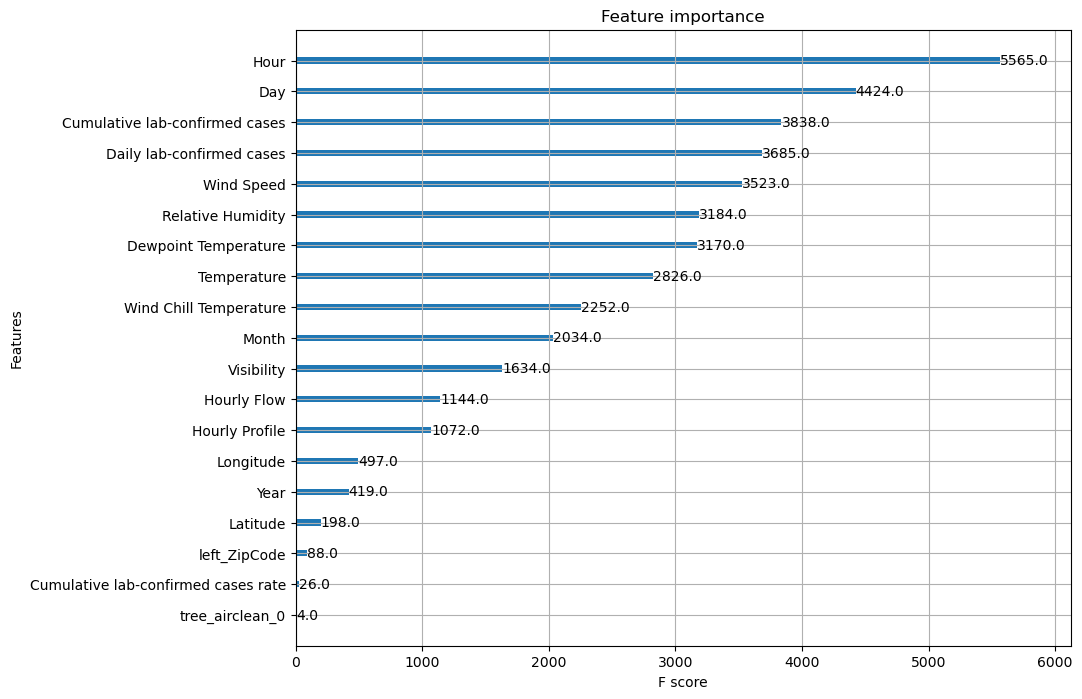

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(clf, ax=ax)
plt.show()


In [54]:
ypred_df = pd.DataFrame({'Year': X_test['Year'],
                          'Month': X_test['Month'],
                          'Day': X_test['Day'],
                          'left_ZipCode': X_test['left_ZipCode'],
                          'AQI_true': y_test,
                          'AQI_pred': y_pred})
ypred_df = ypred_df.sort_values(['Year', 'Month', 'Day', 'left_ZipCode'])
ypred_df['left_ZipCode']= le.inverse_transform(ypred_df['left_ZipCode'])
ypred_df=ypred_df .reset_index(drop=True)
ypred_df
ypred_df.to_csv('D:/学习资料/DataScience/TB2/Mini-project/model/'+'classifier_output.csv', index=False)

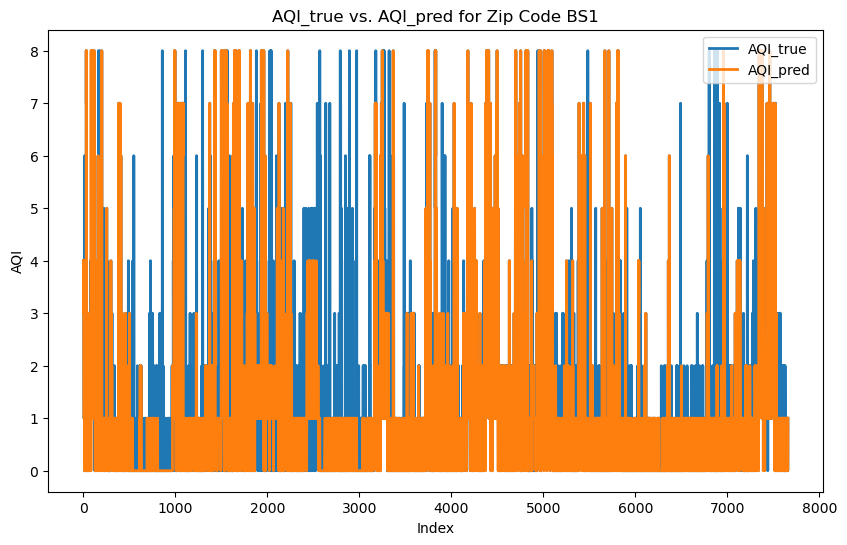

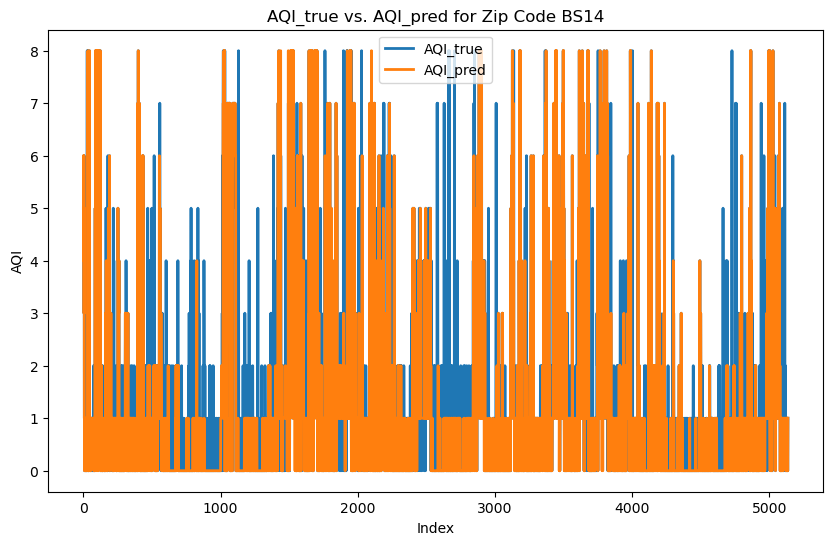

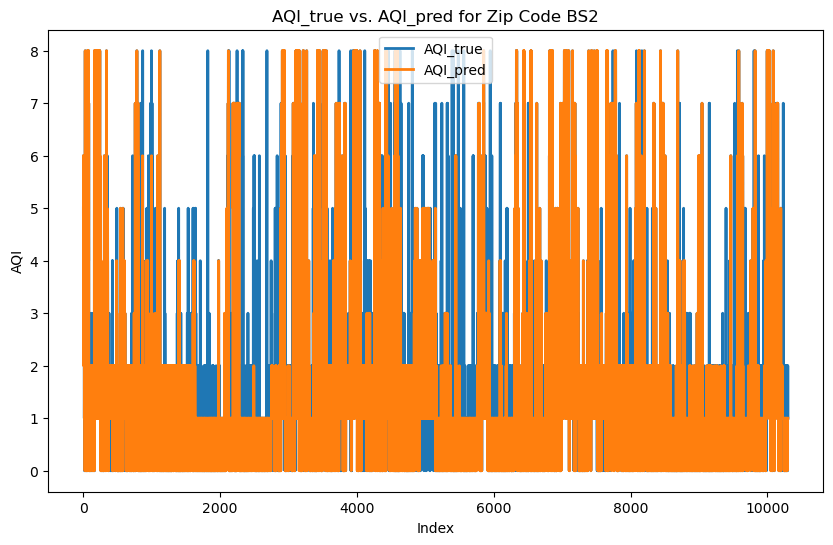

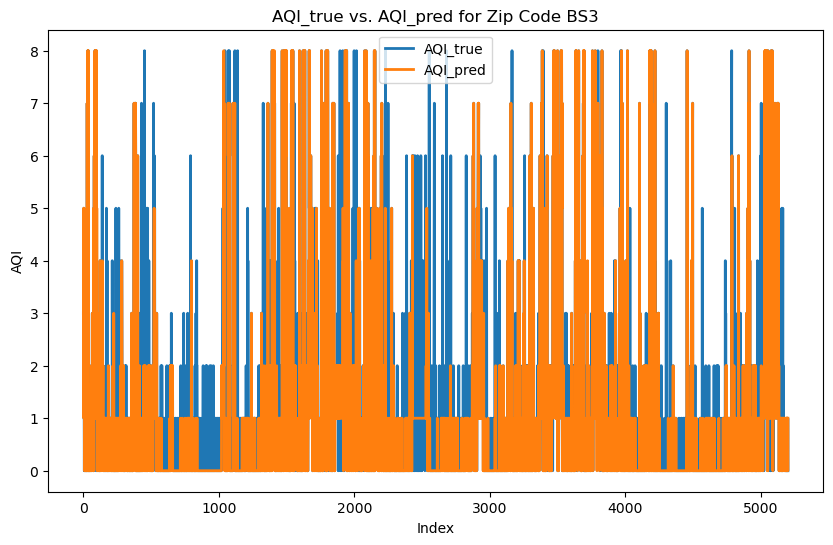

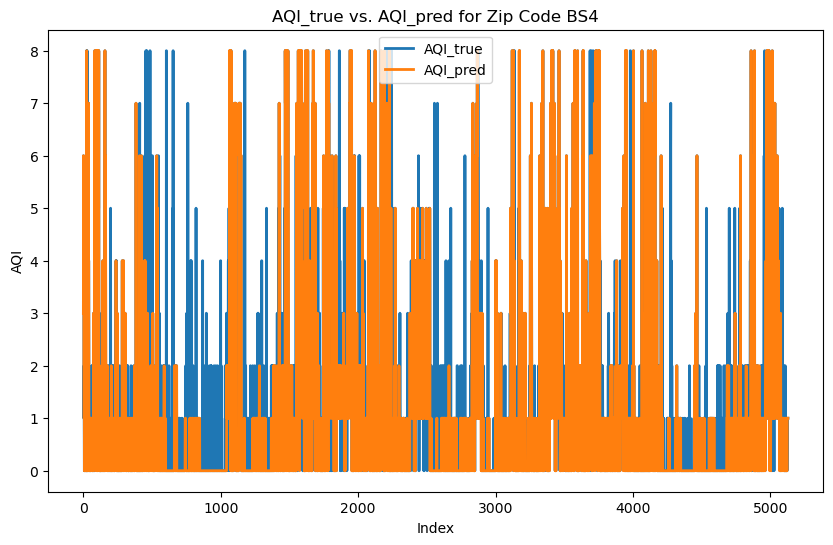

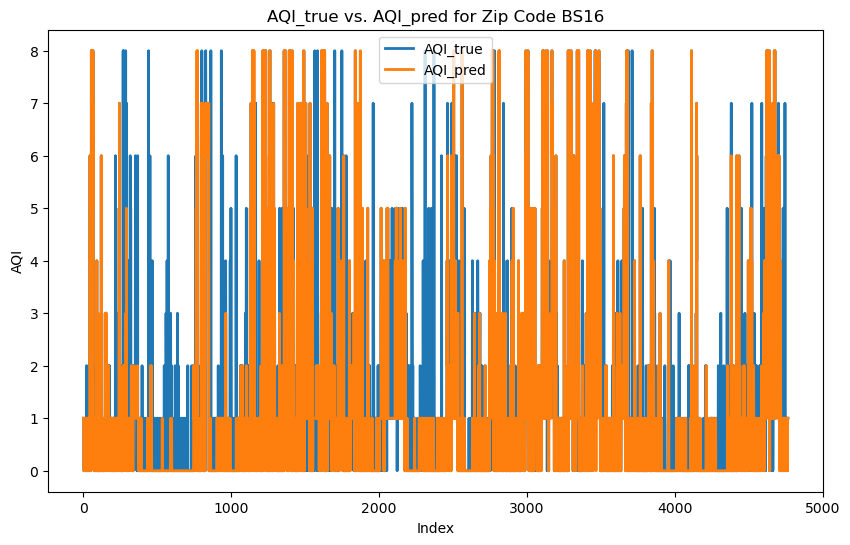

In [55]:
# 获取唯一的left_ZipCode值
zip_codes = ypred_df.left_ZipCode.unique()

# 遍历不同的left_ZipCode值，分别画出折线图
for zip_code in zip_codes:
    # 获取该left_ZipCode的数据
    df = ypred_df[ypred_df.left_ZipCode == zip_code]
    
    # 获取AQI_true和AQI_pred列的数据
    aqi_true = df.AQI_true.values
    aqi_pred = df.AQI_pred.values
    
    # 创建画布并画图
    plt.figure(figsize=(10, 6))
    plt.plot(aqi_true, label='AQI_true', linewidth=2)
    plt.plot(aqi_pred, label='AQI_pred', linewidth=2)
    plt.title('AQI_true vs. AQI_pred for Zip Code {}'.format(zip_code))
    plt.xlabel('Index')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()


In [56]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('MSE:', mse)
print('RMSE:', rmse)


MSE: 1.031655844155844
RMSE: 1.0157046047723934


In [57]:
#Save the image
#fig2.get_figure().savefig('feature_inportance.png',bbox_inches='tight',transparent=True)
#bbox_inches让图片显示完整，transparent=True让图片背景透明